In [2]:
%load_ext autoreload
%autoreload 2

# Common libraries
import numpy as np
import pandas as pd
import os
import datetime as dt

from src.functions import data_import as dimp
from src.functions import data_exploration as dexp
from src.functions import data_transformation as dtr
from src.functions import metric
from src.functions import utils

# Graphics
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly as pty
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.set_config_file(offline=True)

import re
from collections import OrderedDict

# Save images 
DIR = "../../TFM/reports/figures/"
WF = "WF1"
IMAGES_PATH = os.path.join(DIR, WF)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore warnings (SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Algunas pruebas con diferentes modelos

Para establecer un punto de referencia o *benchmark*, probaremos distintos modelos sin profundizar mucho en el tuning de los hiperparámetros. El objetivo es paulatinamente mejorar el rendimiento de los modelos, a base de modificar las fases del proceso (EDA, Feature Engineering, Hyperparameter Tuning, ...).

Elegiremos para conformar nuestro set de entrenamiento:
* Un solo NWP.
* Run de las 00h.
* Día D-1.
* Variables meteorológicas de partida `time`, `U`, `V` y `T`.

In [3]:
# Load data
DATA_PATH = 'C:/Users/Quark/Documents/Mis Cosas/Master/Asignaturas/TFM/Git/TFM/data/raw/'
X_train = dimp.import_data(os.path.join(DATA_PATH, 'X_train_v2.csv'))
X_test = dimp.import_data(os.path.join(DATA_PATH, 'X_test_v2.csv'))
Y_train = dimp.import_data(os.path.join(DATA_PATH, 'Y_train.csv'))

X_train['Time'] = pd.to_datetime(X_train['Time'], format='%d/%m/%Y %H:%M')
X_test['Time'] = pd.to_datetime(X_test['Time'], format='%d/%m/%Y %H:%M')

Memory usage of dataframe is 29.94 MB
Memory usage after optimization is: 7.72 MB
Decreased by 74.2%
Memory usage of dataframe is 29.26 MB


c:\users\quark\documents\mis cosas\master\asignaturas\tfm\git\tfm\src\functions\data_import.py:31: RuntimeWarning:

invalid value encountered in less

c:\users\quark\documents\mis cosas\master\asignaturas\tfm\git\tfm\src\functions\data_import.py:33: RuntimeWarning:

invalid value encountered in less



Memory usage after optimization is: 19.47 MB
Decreased by 33.5%
Memory usage of dataframe is 0.57 MB
Memory usage after optimization is: 0.21 MB
Decreased by 62.5%


In [4]:
def input_missing_values(df, cols):
    
    regex = 'NWP(?P<NWP>\d{1})_(?P<run>\d{2}h)_(?P<fc_day>D\W?\d?)_(?P<weather_var>\w{1,4})'
    p = re.compile(regex)  
    
    NWP_met_vars_dict = {
        '1': ['U','V','T'],
        '2': ['U','V'],
        '3': ['U','V','T'],
        '4': ['U','V','CLCT']
    }
    
    for col in reversed(cols):
        m = p.match(col)
        col_name = 'NWP' + m.group('NWP') + '_' +  m.group('run') + '_' + m.group('fc_day') + '_' + m.group('weather_var')

        for key, value in NWP_met_vars_dict.items():
            for i in value:
                if m.group('NWP') == key and m.group('weather_var') == i:
                    df['NWP'+ key + '_' + i] = df['NWP'+ key + '_' + i].fillna(df[col_name])
    
    return df

In [5]:
from metpy import calc
from metpy.units import units

# function to obtain the module of wind velocity
get_wind_velmod = lambda x : float(calc.wind_speed(
    x.U * units.meter/units.second, 
    x.V * units.meter/units.second
).magnitude)

# function to obtain the wind direction
get_wind_dir = lambda x : float(calc.wind_direction(
    x.U * units.meter/units.second, 
    x.V * units.meter/units.second, 
    convention="from"
).magnitude)

## Regresión con KNN

In [67]:
# Automatización de pre-procesado, modelización, validación y prediccion
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from src.functions import metric
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.neighbors import KNeighborsRegressor
import re
from collections import OrderedDict
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import OneClassSVM
from sklearn.metrics import r2_score, median_absolute_error
import hdbscan


# Lista de WFs
WF_lst = X_train['WF'].unique()

# lista para guardar los modelos y los scores de cada WF
models = []
scores_list = []

# Data frame para guardar las predicciones (ID, Production)
submission_df = pd.DataFrame([], columns=['ID','Production']) 

for WF in WF_lst:
    # Creamos copia de los datos para no perder su formato inicial
    X_train_cpy = X_train.copy()
    Y_train_cpy = Y_train.copy()
    X_test_cpy = X_test.copy()

    # Selección de filas por WF
    X_train_cpy = X_train_cpy[X_train_cpy['WF'] == WF]
    X_test_cpy = X_test_cpy[X_test_cpy['WF'] == WF]

    # Identificador de observaciones
    ID_train = X_train_cpy['ID']
    ID_test = X_test_cpy['ID']

    # Seleccion de las filas de Y_train
    Y_train_cpy = Y_train_cpy['Production']
    Y_train_cpy = Y_train_cpy.loc[ID_train.values - 1]

    # Pre-procesado de los datos en bruto

    # We'll add new columns NWPX_<met_var> without missing values
    # new cols: NWP1_U, NWP1_V, NWP1_T, NWP2_U, NWP2_V, NWP3_U, NWP3_V, NWP3_T, NWP4_U, NWP4_V, NWP4_CLCT
    
    new_cols = ['NWP1_U','NWP1_V','NWP1_T','NWP2_U',
                'NWP2_V','NWP3_U','NWP3_V','NWP3_T',
                'NWP4_U','NWP4_V','NWP4_CLCT']

    def add_new_cols(new_cols, df):
        for col in new_cols:
            df[col] = np.nan    
            
    add_new_cols(new_cols, X_train_cpy)
    add_new_cols(new_cols, X_test_cpy)
    
    cols_train = X_train.columns[3:]
    cols_test = X_test.columns[3:-9]
    X_train_cpy = input_missing_values(X_train_cpy, cols_train)
    X_test_cpy = input_missing_values(X_test_cpy, cols_test)
    
    col_list = ['NWP2_U','NWP2_V','NWP3_U','NWP3_V','NWP3_T']
    X_train_cpy.index = X_train_cpy['Time']
    
    del X_train_cpy['Time']
        
    for var in col_list:
        X_train_cpy[var].interpolate(
            method='time', 
            inplace=True,
            limit=2,
            limit_direction='both'
        )
        
    X_train_cpy.reset_index(inplace=True)
    
    X_test_cpy.index = X_test_cpy['Time']
    
    del X_test_cpy['Time']
        
    for var in col_list:
        X_test_cpy[var].interpolate(
            method='time', 
            inplace=True,
            limit=100,
            limit_direction='both'
        )
    
        
    X_test_cpy.reset_index(inplace=True) 
    

    X_train_cpy['U'] = X_train_cpy.NWP1_U
    X_train_cpy['V'] = X_train_cpy.NWP1_V
    X_train_cpy['T'] = X_train_cpy.NWP3_T
    X_train_cpy['CLCT'] = X_train_cpy.NWP4_CLCT
    
    X_test_cpy['U'] = X_test_cpy.NWP1_U
    X_test_cpy['V'] = X_test_cpy.NWP1_V
    X_test_cpy['T'] = X_test_cpy.NWP3_T
    X_test_cpy['CLCT'] = X_test_cpy.NWP4_CLCT
 
    X_train_cpy = X_train_cpy[['ID','Time','U','V','T','CLCT']]
    X_test_cpy = X_test_cpy[['ID','Time','U','V','T','CLCT']]
    
    # Hay 11 valores perdidos en la columna CLCT en X_test_cpy. Los imputamos
    X_test_cpy.fillna(method='bfill', limit=11, inplace=True)

    ####### Limpiar outliers #######
    # Negative values in CLCT
    X_train_cpy.loc[X_train_cpy['CLCT'] < 0, 'CLCT'] = 0.0
    X_test_cpy.loc[X_test_cpy['CLCT'] < 0, 'CLCT'] = 0.0
    
    # Locating and removing outliers based on wind power curve
    # Add 'Production' column
    X_train_cpy['Production'] = Y_train_cpy.to_list()
    
    # Calculate wind velocity module
    X_train_cpy['vel'] = X_train_cpy.apply(dtr.get_wind_velmod, axis=1)
    
    # Build data matrix
    mm = PowerTransformer(method='yeo-johnson', standardize=True)
    
    X1 = mm.fit_transform(X_train_cpy['vel'].values.reshape(-1,1))
    X2 = mm.fit_transform(X_train_cpy['Production'].values.reshape(-1,1))
    X = np.concatenate((X1,X2), axis=1)
    
    # Using DBSCAN to find outliers
    from sklearn.cluster import DBSCAN
    outlier_detection = DBSCAN(
        eps = 0.1,
        metric="l1",
        min_samples = 10,
        n_jobs = -1)
    
    clusters = outlier_detection.fit_predict(X)
    outliers = np.where(clusters == -1)[0]

    # Deleting columns 'vel' and 'Production'
    del X_train_cpy['vel']
    del X_train_cpy['Production']
    ###################################

    # Pre-procesado de los datos
    pre_process = ColumnTransformer(remainder = 'passthrough',
                                    transformers = [('drop_columns', 'drop', ['ID','Time','U','V','CLCT','T',
                                                                              'month','hour','hour_sin','month_sin',
                                                                              'month_cos','hour_cos','w_dir_cos','w_dir_sin'])]
    )
    

    # definir pipeline
    prepare_data_pipeline = Pipeline(steps=[
        ('attr_adder', dtr.NewFeaturesAdder(add_time_feat=True, add_cycl_feat=True, add_inv_T=False)), 
        ('pre_processing', pre_process),
        ('power_transf', PowerTransformer(method='yeo-johnson', standardize=True))
    ])
    
    # aplicar pipeline
    X_train_pped = prepare_data_pipeline.fit_transform(X_train_cpy)
    
    # Deleting outlier related observations
    X_train_pped = np.delete(X_train_pped, tuple(outliers), axis=0)

    # Deleting the corresponding observations in y_train
    Y_train_cpy = np.delete(Y_train_cpy.to_numpy(), list(outliers))

    # creamos nuestro scorer basado en el CAPE
    cape_scorer = make_scorer(metric.get_cape, greater_is_better=False)

    # Modelización KNN: implementación en GridSearchCV
    param_grid = [
        {
            'n_neighbors': list(range(1,50,2)),
            'algorithm':['auto', 'kd_tree'],
            'weights': ['uniform','distance'],
            'metric': ['cityblock'],
            'p': [1,2]
        }
    ]
    
    cv = TimeSeriesSplit(n_splits=7)
    knn_reg = KNeighborsRegressor()
    grid_search_knn = GridSearchCV(
        knn_reg, 
        param_grid, 
        cv= cv,
        n_jobs=-1,
        scoring=cape_scorer
    )

    grid_search_knn.fit(X_train_pped, Y_train_cpy)
    
    # Reentrenamos sin validación cruzada utilizando los mejores 
    # parámetros obtenidos con la validación cruzada
    
    knn_reg2 = KNeighborsRegressor(algorithm=grid_search_knn.best_params_['algorithm'],
                                   n_neighbors=grid_search_knn.best_params_['n_neighbors'],
                                   p=grid_search_knn.best_params_['p'], 
                                   weights=grid_search_knn.best_params_['weights'],
                                   metric=grid_search_knn.best_params_['metric'])
    
    ttreg = TransformedTargetRegressor(regressor=knn_reg2, 
                                       transformer=PowerTransformer(method='yeo-johnson', standardize=True), 
                                       check_inverse=False)

    ttreg.fit(X_train_pped, Y_train_cpy)

    # evaluación sobre el conjunto de test
    X_test_pped = prepare_data_pipeline.transform(X_test_cpy)
    predictions = ttreg.predict(X_test_pped)
    
    # build prediction matrix (ID,Production)
    pred_matrix = np.stack((np.array(ID_test).astype(int), predictions), axis=-1)
    df_pred = pd.DataFrame(data=pred_matrix, columns=['ID','Production'])
    
    # añadimos las predicciones al dataframe final que contendrá las de todas las WF
    submission_df = submission_df.append(df_pred, ignore_index=True) 
    print('Best CV score:', -grid_search_knn.best_score_)
    print('Predictions for {} has been added to submission_df'.format(WF))
    print('---------------')

# generamos fichero csv para el submission
submission_df.to_csv("../../TFM/models/knn.csv", index=False, sep=",") 

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning:

overflow encountered in reduce



Best CV score: 36.670680840302715
Predictions for WF1 has been added to submission_df
---------------


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning:

overflow encountered in reduce



Best CV score: 32.303047406775434
Predictions for WF2 has been added to submission_df
---------------


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning:

overflow encountered in reduce



Best CV score: 31.198452825734517
Predictions for WF3 has been added to submission_df
---------------


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning:

overflow encountered in reduce



Best CV score: 29.26950505935398
Predictions for WF4 has been added to submission_df
---------------


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning:

overflow encountered in reduce



Best CV score: 36.74533328625266
Predictions for WF5 has been added to submission_df
---------------


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning:

overflow encountered in reduce



Best CV score: 29.264321602083083
Predictions for WF6 has been added to submission_df
---------------


In [66]:
X_train_pped.shape

(5770, 2)

## Prueba 1: Regresión polinomial con regularización *ridge*

In [6]:
# Automatización de pre-procesado, modelización, validación y prediccion
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from src.functions import metric
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model as lm
from sklearn.linear_model import RidgeCV

# Lista de WFs
WF_lst = X_train['WF'].unique()

# lista para guardar los modelos, uno por WF
models = []

# Data frame para guardar las predicciones (ID, Production)
submission_df = pd.DataFrame([], columns=['ID','Production']) 

for WF in WF_lst:
    # Creamos copia de los datos para no perder su formato inicial
    X_train_cpy = X_train.copy()
    Y_train_cpy = Y_train.copy()
    X_test_cpy = X_test.copy()

    # Selección de filas por WF
    X_train_cpy = X_train_cpy[X_train_cpy['WF'] == WF]
    X_test_cpy = X_test_cpy[X_test_cpy['WF'] == WF]

    # Identificador de observaciones
    ID_train = X_train_cpy['ID']
    ID_test = X_test_cpy['ID']

    # Seleccion de las filas de Y_train
    Y_train_cpy = Y_train_cpy['Production']
    Y_train_cpy = Y_train_cpy.loc[ID_train.values - 1]

    # Pre-procesado de los datos en bruto

    # We'll add new columns NWPX_<met_var> without missing values
    # new cols: NWP1_U, NWP1_V, NWP1_T, NWP2_U, NWP2_V, NWP3_U, NWP3_V, NWP3_T, NWP4_U, NWP4_V, NWP4_CLCT
    
    new_cols = ['NWP1_U','NWP1_V','NWP1_T','NWP2_U',
                'NWP2_V','NWP3_U','NWP3_V','NWP3_T',
                'NWP4_U','NWP4_V','NWP4_CLCT']

    def add_new_cols(new_cols, df):
        for col in new_cols:
            df[col] = np.nan    
            
    add_new_cols(new_cols, X_train_cpy)
    add_new_cols(new_cols, X_test_cpy)
    
    cols_train = X_train.columns[3:]
    cols_test = X_test.columns[3:-9]
    X_train_cpy = input_missing_values(X_train_cpy, cols_train)
    X_test_cpy = input_missing_values(X_test_cpy, cols_test)
    
    col_list = ['NWP2_U','NWP2_V','NWP3_U','NWP3_V','NWP3_T']
    X_train_cpy.index = X_train_cpy['Time']
    
    del X_train_cpy['Time']
        
    for var in col_list:
        X_train_cpy[var].interpolate(
            method='time', 
            inplace=True,
            limit=2,
            limit_direction='both'
        )

    
    X_train_cpy.reset_index(inplace=True)

    X_test_cpy.index = X_test_cpy['Time']
    
    del X_test_cpy['Time']
        
    for var in col_list:
        X_test_cpy[var].interpolate(
            method='time', 
            inplace=True,
            limit=100,
            limit_direction='both'
        )
    
        
    X_test_cpy.reset_index(inplace=True) 

    X_train_cpy['U'] = (X_train_cpy.NWP1_U + X_train_cpy.NWP2_U + X_train_cpy.NWP3_U + X_train_cpy.NWP4_U)/4
    X_train_cpy['V'] = (X_train_cpy.NWP1_V + X_train_cpy.NWP2_V + X_train_cpy.NWP3_V + X_train_cpy.NWP4_V)/4
    X_train_cpy['T'] = (X_train_cpy.NWP1_T + X_train_cpy.NWP3_T)/2
    X_train_cpy['CLCT'] = (X_train_cpy.NWP4_CLCT)
    X_train_cpy['T2'] = np.sqrt(X_train_cpy['T'])
    
    X_test_cpy['U'] = (X_test_cpy.NWP1_U + X_test_cpy.NWP2_U + X_test_cpy.NWP3_U)/3
    X_test_cpy['V'] = (X_test_cpy.NWP1_V + X_test_cpy.NWP2_V + X_test_cpy.NWP3_V)/3
    X_test_cpy['T'] = (X_test_cpy.NWP1_T + X_test_cpy.NWP3_T)/2
    X_test_cpy['CLCT'] = (X_test_cpy.NWP4_CLCT)
    X_test_cpy['T2'] = np.sqrt(X_test_cpy['T'])

    
    
    X_train_cpy = X_train_cpy[['Time','U','V','T','CLCT','T2']]
    X_test_cpy = X_test_cpy[['Time','U','V','T','CLCT','T2']]
    
    # Hay 11 valores perdidos en la columna CLCT en X_test_cpy. Los imputamos con la moda
    X_test_cpy.fillna(method='bfill', limit=11, inplace=True)


    # Pre-procesado de los datos
    pre_process = ColumnTransformer(remainder = 'passthrough',
                                    transformers = [('drop_columns', 'drop',
                                                     ['Time','U','V','T','CLCT','T2'])]
    )

    # definir pipeline
    prepare_data_pipeline = Pipeline(steps=[
        ('attr_adder', dtr.DerivedAttributesAdder(add_time_feat=False, add_cyclic_feat=False, add_vel_pot=False)), 
        ('pre_processing', pre_process),
        ('std_scaler', StandardScaler())
    ])

    # aplicar pipeline
    X_train_pped = prepare_data_pipeline.fit_transform(X_train_cpy)

    # creamos nuestro scorer basado en el CAPE
    cape_scorer = make_scorer(metric.get_cape, greater_is_better=False)

    # Modelización: Regresión polinomial utilizando CV con regularización tipo Ride
    poly_features = PolynomialFeatures(degree=3, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train_pped)
    
    rreg = lm.RidgeCV(alphas=np.logspace(-4, -3, 3, 4), store_cv_values=True)
    rreg.fit(X_train_poly, Y_train_cpy)
    
    # guardamos modelo
    models.append(joblib.dump(rreg, WF + '_rreg'))

    # evaluación sobre el conjunto de test
    X_test_pped = prepare_data_pipeline.transform(X_test_cpy)
    X_test_poly = poly_features.fit_transform(X_test_pped)
    predictions = rreg.predict(X_test_poly)
    
    # generamos matriz de predicciones (ID,Production)
    pred_matrix = np.stack((np.array(ID_test).astype(int), predictions), axis=-1)
    df_pred = pd.DataFrame(data=pred_matrix, columns=['ID','Production'])

    # añadimos las predicciones al dataframe final que contendrá las de todas las WF
    submission_df = submission_df.append(df_pred, ignore_index=True) 
    print('Predictions for {} has been added to submission_df'.format(WF))
    print('RMSE for {} is {}'.format(WF, np.mean(np.sqrt(rreg.cv_values_))))

# generamos fichero csv para el submission
submission_df.to_csv("../../TFM/models/submission_rreg.csv", index=False, sep=",") 

AttributeError: module 'src.functions.data_transformation' has no attribute 'DerivedAttributesAdder'

In [ ]:
X_train_cpy

In [ ]:
nans = pd.DataFrame(data=np.isnan(X_test_pped).flatten())

## Prueba 2: Random Forest 

In [ ]:
# Automatización de pre-procesado, modelización, validación y prediccion
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from src.functions import metric
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
import re
from collections import OrderedDict


# Lista de WFs
WF_lst = X_train['WF'].unique()

# lista para guardar los modelos, uno por WF
models = []

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Data frame para guardar las predicciones (ID, Production)
submission_df = pd.DataFrame([], columns=['ID','Production']) 

for WF in WF_lst:
    # Creamos copia de los datos para no perder su formato inicial
    X_train_cpy = X_train.copy()
    Y_train_cpy = Y_train.copy()
    X_test_cpy = X_test.copy()

    # Selección de filas por WF
    X_train_cpy = X_train_cpy[X_train_cpy['WF'] == WF]
    X_test_cpy = X_test_cpy[X_test_cpy['WF'] == WF]

    # Identificador de observaciones
    ID_train = X_train_cpy['ID']
    ID_test = X_test_cpy['ID']

    # Seleccion de las filas de Y_train
    Y_train_cpy = Y_train_cpy['Production']
    Y_train_cpy = Y_train_cpy.loc[ID_train.values - 1]

    # Pre-procesado de los datos en bruto

    # We'll add new columns NWPX_<met_var> without missing values
    # new cols: NWP1_U, NWP1_V, NWP1_T, NWP2_U, NWP2_V, NWP3_U, NWP3_V, NWP3_T, NWP4_U, NWP4_V, NWP4_CLCT
    
    new_cols = ['NWP1_U','NWP1_V','NWP1_T','NWP2_U',
                'NWP2_V','NWP3_U','NWP3_V','NWP3_T',
                'NWP4_U','NWP4_V','NWP4_CLCT']

    def add_new_cols(new_cols, df):
        for col in new_cols:
            df[col] = np.nan    
            
    add_new_cols(new_cols, X_train_cpy)
    add_new_cols(new_cols, X_test_cpy)
    
    cols_train = X_train_cpy.columns[3:-11]
    cols_test = X_test_cpy.columns[3:-11]
    X_train_cpy = input_missing_values(X_train_cpy, cols_train)
    X_test_cpy = input_missing_values(X_test_cpy, cols_train)
    
    col_list = ['NWP2_U','NWP2_V','NWP3_U','NWP3_V','NWP3_T']
    X_train_cpy.index = X_train_cpy['Time']
    
    del X_train_cpy['Time']
        
    for var in col_list:
        X_train_cpy[var].interpolate(
            method='time', 
            inplace=True,
            limit=2,
            limit_direction='both'
        )

    
    X_train_cpy.reset_index(inplace=True)

    X_test_cpy.index = X_test_cpy['Time']
    
    del X_test_cpy['Time']
        
    for var in col_list:
        X_test_cpy[var].interpolate(
            method='time', 
            inplace=True,
            limit=100,
            limit_direction='both'
        )
    
        
    X_test_cpy.reset_index(inplace=True) 

    X_train_cpy['U'] = (X_train_cpy.NWP1_U + X_train_cpy.NWP2_U + X_train_cpy.NWP3_U + X_train_cpy.NWP4_U)/4
    X_train_cpy['V'] = (X_train_cpy.NWP1_V + X_train_cpy.NWP2_V + X_train_cpy.NWP3_V + X_train_cpy.NWP4_V)/4
    X_train_cpy['T'] = (X_train_cpy.NWP1_T + X_train_cpy.NWP3_T)/2
    X_train_cpy['CLCT'] = (X_train_cpy.NWP4_CLCT)
    
    X_test_cpy['U'] = (X_test_cpy.NWP1_U + X_test_cpy.NWP2_U + X_test_cpy.NWP3_U)/3
    X_test_cpy['V'] = (X_test_cpy.NWP1_V + X_test_cpy.NWP2_V + X_test_cpy.NWP3_V)/3
    X_test_cpy['T'] = (X_test_cpy.NWP1_T + X_test_cpy.NWP3_T)/2
    X_test_cpy['CLCT'] = (X_test_cpy.NWP4_CLCT)

    
    
    X_train_cpy = X_train_cpy[['Time','U','V','T','CLCT']]
    X_test_cpy = X_test_cpy[['Time','U','V','T','CLCT']]

    
    ## Limpieza de datos: imputar valores perdidos en X_
    #only_na = X_test_cpy[~X_test_cpy.ID.isin(X_test_cpy.dropna().ID)]
    #X_test_cpy.dropna(inplace=True)
    #Y_train_cpy.drop(labels=only_na.index, axis=0, inplace=True)
    #X_train_cpy.drop(labels=only_na.index, axis=0, inplace=True)

    # Pre-procesado de los datos
    pre_process = ColumnTransformer(remainder = 'passthrough',
                                    transformers = [('drop_columns', 'drop', 
                                                     ['Time','U','V','hour','month','day_of_week'])]
    )

    # definir pipeline
    prepare_data_pipeline = Pipeline(steps=[
        ('attr_adder', dtr.DerivedAttributesAdder(add_time_feat=True, add_cyclic_feat=False)), 
        ('pre_processing', pre_process),
        ('power_transf', PowerTransformer(method='yeo-johnson', standardize=True))
    ])

    # aplicar pipeline
    X_train_pped = prepare_data_pipeline.fit_transform(X_train_cpy)

    # creamos nuestro scorer basado en el CAPE
    cape_scorer = make_scorer(metric.get_cape, greater_is_better=False)


    # Modelización: Random Forest
    # Entrenamiento del modelo mediante k-fold cross validation
    # Búsqueda de hiperparámetros mediante Gridsearch 
    # param_grid = [
    #    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    #    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    #]

    forest_reg = RandomForestRegressor()
    grid_search = GridSearchCV(
        forest_reg, 
        random_grid, 
        cv=5,
        scoring=cape_scorer,
        n_jobs=4
    )

    grid_search.fit(X_train_pped, Y_train_cpy)
    final_model = grid_search.best_estimator_

    # guardamos modelo
    #models.append(joblib.dump(final_model, WF))

    # evaluación sobre el conjunto de test
    X_test_pped = prepare_data_pipeline.transform(X_test_cpy)
    predictions = final_model.predict(X_test_pped)

    # generamos matriz de predicciones (ID,Production)
    pred_matrix = np.stack((np.array(ID_test).astype(int), predictions), axis=-1)
    df_pred = pd.DataFrame(data=pred_matrix, columns=['ID','Production'])

    # añadimos las predicciones al dataframe final que contendrá las de todas las WF
    submission_df = submission_df.append(df_pred, ignore_index=True)  
    print('Best score for {}: {}'.format(WF, -grid_search.best_score_))
    print('Predictions for {} has been added to submission_df'.format(WF))
    print('--------')

# generamos fichero csv para el submission
submission_df.to_csv("../../TFM/models/submission_RF.csv", index=False, sep=",") 

## Prueba 3: SVM 

In [14]:
# Automatización de pre-procesado, modelización, validación y prediccion
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from src.functions import metric
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.externals import joblib
import re
from collections import OrderedDict
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
import hdbscan

# Lista de WFs
WF_lst = X_train['WF'].unique()

# lista para guardar los modelos, uno por WF
models = []
scores_list = []

# Data frame para guardar las predicciones (ID, Production)
submission_df = pd.DataFrame([], columns=['ID','Production']) 



for WF in WF_lst:
    # Creamos copia de los datos para no perder su formato inicial
    X_train_cpy = X_train.copy()
    Y_train_cpy = Y_train.copy()
    X_test_cpy = X_test.copy()

    # Selección de filas por WF
    X_train_cpy = X_train_cpy[X_train_cpy['WF'] == WF]
    X_test_cpy = X_test_cpy[X_test_cpy['WF'] == WF]

    # Identificador de observaciones
    ID_train = X_train_cpy['ID']
    ID_test = X_test_cpy['ID']

    # Seleccion de las filas de Y_train
    Y_train_cpy = Y_train_cpy['Production']
    Y_train_cpy = Y_train_cpy.loc[ID_train.values - 1]

    # Pre-procesado de los datos en bruto

    # We'll add new columns NWPX_<met_var> without missing values
    # new cols: NWP1_U, NWP1_V, NWP1_T, NWP2_U, NWP2_V, NWP3_U, NWP3_V, NWP3_T, NWP4_U, NWP4_V, NWP4_CLCT
    
    new_cols = ['NWP1_U','NWP1_V','NWP1_T','NWP2_U',
                'NWP2_V','NWP3_U','NWP3_V','NWP3_T',
                'NWP4_U','NWP4_V','NWP4_CLCT']

    def add_new_cols(new_cols, df):
        for col in new_cols:
            df[col] = np.nan    
            
    add_new_cols(new_cols, X_train_cpy)
    add_new_cols(new_cols, X_test_cpy)
    
    cols_train = X_train.columns[3:]
    cols_test = X_test.columns[3:-9]
    X_train_cpy = input_missing_values(X_train_cpy, cols_train)
    X_test_cpy = input_missing_values(X_test_cpy, cols_test)
    
    col_list = ['NWP2_U','NWP2_V','NWP3_U','NWP3_V','NWP3_T']
    X_train_cpy.index = X_train_cpy['Time']
    
    del X_train_cpy['Time']
        
    for var in col_list:
        X_train_cpy[var].interpolate(
            method='time', 
            inplace=True,
            limit=2,
            limit_direction='both'
        )

    
    X_train_cpy.reset_index(inplace=True)

    X_test_cpy.index = X_test_cpy['Time']
    
    del X_test_cpy['Time']
        
    for var in col_list:
        X_test_cpy[var].interpolate(
            method='time', 
            inplace=True,
            limit=100,
            limit_direction='both'
        )
    
        
    X_test_cpy.reset_index(inplace=True) 

    X_train_cpy['U'] = X_train_cpy.NWP1_U
    X_train_cpy['V'] = X_train_cpy.NWP1_V
    X_train_cpy['T'] = X_train_cpy.NWP3_T
    X_train_cpy['CLCT'] = X_train_cpy.NWP4_CLCT
    
    X_test_cpy['U'] = X_test_cpy.NWP1_U
    X_test_cpy['V'] = X_test_cpy.NWP1_V
    X_test_cpy['T'] = X_test_cpy.NWP3_T
    X_test_cpy['CLCT'] = X_test_cpy.NWP4_CLCT
 
    X_train_cpy = X_train_cpy[['ID','Time','U','V','T','CLCT']]
    X_test_cpy = X_test_cpy[['ID','Time','U','V','T','CLCT']]
    
    # Hay 11 valores perdidos en la columna CLCT en X_test_cpy. Los imputamos con la moda
    X_test_cpy.fillna(method='bfill', limit=11, inplace=True)
    
    
    # valores negativos en CLCT
    X_train_cpy.loc[X_train_cpy['CLCT'] < 0, 'CLCT'] = 0.0
    X_test_cpy.loc[X_test_cpy['CLCT'] < 0, 'CLCT'] = 0.0

    
    # Pre-procesado de los datos
    pre_process = ColumnTransformer(remainder = 'passthrough',
                                    transformers = [('drop_columns', 'drop', 
                                                     ['ID','Time','U','V','CLCT','month'])]
    )

    # definir pipeline
    prepare_data_pipeline = Pipeline(steps=[
        ('attr_adder', dtr.NewFeaturesAdder(add_inv_T=False, add_cycl_feat=False)), 
        ('pre_processing', pre_process),
        ('std_scaler', PowerTransformer(method='yeo-johnson', standardize=True))
    ])

    # aplicar pipeline
    X_train_pped = prepare_data_pipeline.fit_transform(X_train_cpy)
    
    ####### Limpieza de outliers ########
    
    # añadir columna Production
    X_train_cpy['Production'] = Y_train_cpy.to_list()
    
    # calcular módulo velocidad del viento
    X_train_cpy['vel'] = X_train_cpy.apply(get_wind_velmod, axis=1)
    
    # formar matriz de datos 
    mm = PowerTransformer(method='yeo-johnson', standardize=True)
    X1 = mm.fit_transform(np.array(X_train_cpy['vel']).reshape(-1,1))
    X2 = mm.fit_transform(np.array(X_train_cpy['Production']).reshape(-1,1))
    X = np.concatenate((X1,X2), axis=1)
    
    # algoritmo para detección de outliers
    clusterer = hdbscan.HDBSCAN(min_cluster_size=20).fit(X)
    threshold = pd.Series(clusterer.outlier_scores_).quantile(0.95)
    outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
    
    # Eliminamos los registros outliers 
    X_train_pped = np.delete(X_train_pped, outliers, axis=0)
    
    # Eliminamos las observaciones corresp#ondientes de Y_train
    Y_train_cpy = np.delete(X2, outliers, axis=0)
    
    # Eliminamos las columnas 'vel' y 'Production'
    del X_train_cpy['vel']
    del X_train_cpy['Production']
    
    ###################################
    
    '''
    print('Nº features antes de la seleccion: ', X_train_pped.shape[1])
    # seleccionar features más importantes mediante Random Forest
    rf = RandomForestRegressor(random_state=42)
    rf_reg = rf.fit(X_train_pped, Y_train_cpy)
    sel = SelectFromModel(rf_reg, prefit=True, threshold='1.75*median')
    X_train_pped = sel.transform(X_train_pped)
    
    print('Nº features después de la seleccion: ', X_train_pped.shape[1])
    '''
  

    # creamos nuestro scorer basado en el CAPE
    cape_scorer = make_scorer(metric.get_cape, greater_is_better=False)

    # Entrenamiento del modelo mediante k-fold cross validation
    # Búsqueda de hiperparámetros mediante Gridsearch 
    param_grid = {
        'kernel': ('linear', 'rbf','poly'), 
        'C':[0.01, 1, 0.1, 10],
        'gamma': [0.00001, 0.001, 1],
        'epsilon':[0.1,0.3,0.5]
    }

    svm_reg = SVR()
    grid_search_svm = GridSearchCV(
        svm_reg, 
        param_grid, 
        cv= TimeSeriesSplit(n_splits=7),
        scoring=cape_scorer,
        n_jobs=-1
    )

    grid_search_svm.fit(X_train_pped, Y_train_cpy)

    # Reentrenamos sin validación cruzada utilizando los mejores 
    # parámetros obtenidos con la validación cruzada
    
    svm_reg2 = SVR(kernel = grid_search_svm.best_params_['kernel'],
                  C = grid_search_svm.best_params_['C'],
                  gamma = grid_search_svm.best_params_['gamma'],
                  epsilon = grid_search_svm.best_params_['epsilon'])
    
    ttreg = TransformedTargetRegressor(regressor=svm_reg2, 
                                       transformer=PowerTransformer(method='yeo-johnson', standardize=True), 
                                       check_inverse=False)

    ttreg.fit(X_train_pped, Y_train_cpy)

    # evaluación sobre el conjunto de test
    X_test_pped = prepare_data_pipeline.transform(X_test_cpy)
    # X_test_pped = sel.transform(X_test_pped)
    predictions = ttreg.predict(X_test_pped)
    
    # generamos matriz de predicciones (ID,Production)
    pred_matrix = np.stack((np.array(ID_test).astype(int), predictions), axis=-1)
    df_pred = pd.DataFrame(data=pred_matrix, columns=['ID','Production'])

    # añadimos las predicciones al dataframe final que contendrá las de todas las WF
    submission_df = submission_df.append(df_pred, ignore_index=True) 
    print('R2 for {} is {}'.format(WF, ttreg.score(X_train_pped, Y_train_cpy)))
    print('Predictions for {} has been added to submission_df'.format(WF))
    
    scores_list.append(ttreg.score(X_train_pped, Y_train_cpy))
    
global_score = np.mean(scores_list)

print('********************************************')
print('Global score: ', global_score)
print('********************************************')


# generamos fichero csv para el submission
submission_df.to_csv("../../TFM/models/submission_SVR.csv", index=False, sep=",") 

C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ValueError: all input arrays must have the same shape

In [8]:
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1,3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


## Prueba 4: XGBoost

R2 for WF1 is 0.9269997790278087
Predictions for WF1 has been added to submission_df


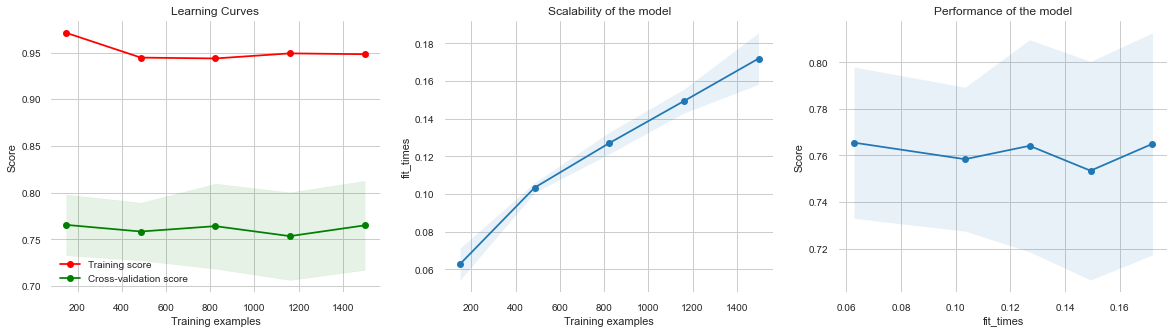

R2 for WF2 is 0.9147915464566285
Predictions for WF2 has been added to submission_df


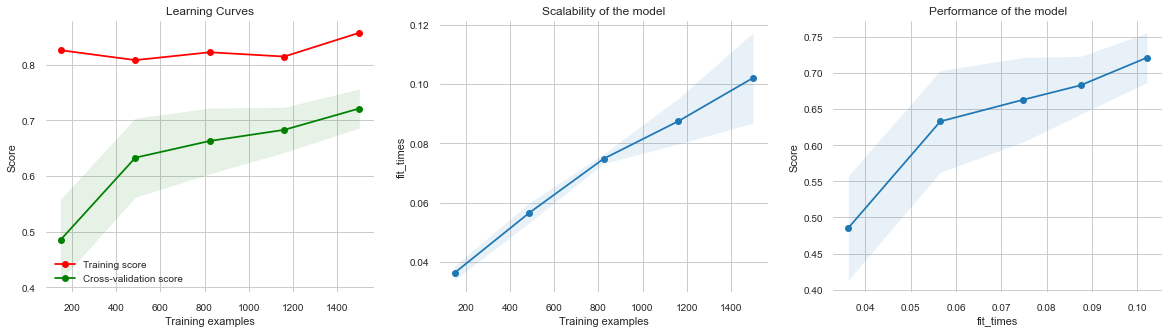

R2 for WF3 is 0.9082948227653047
Predictions for WF3 has been added to submission_df


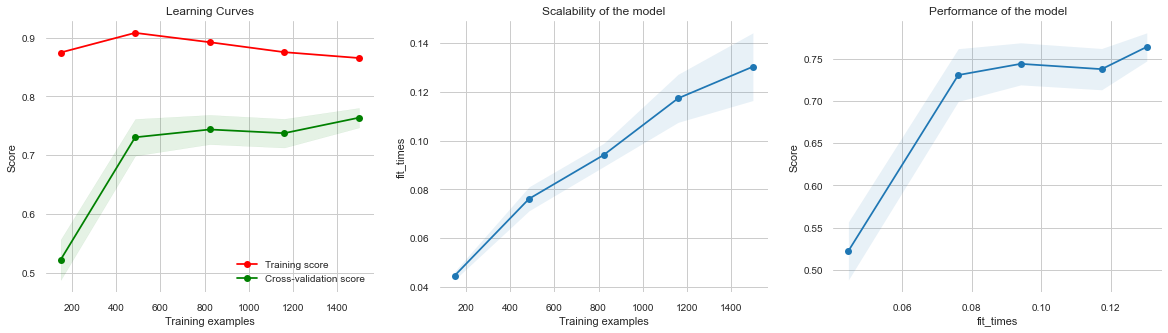

R2 for WF4 is 0.945734379551009
Predictions for WF4 has been added to submission_df


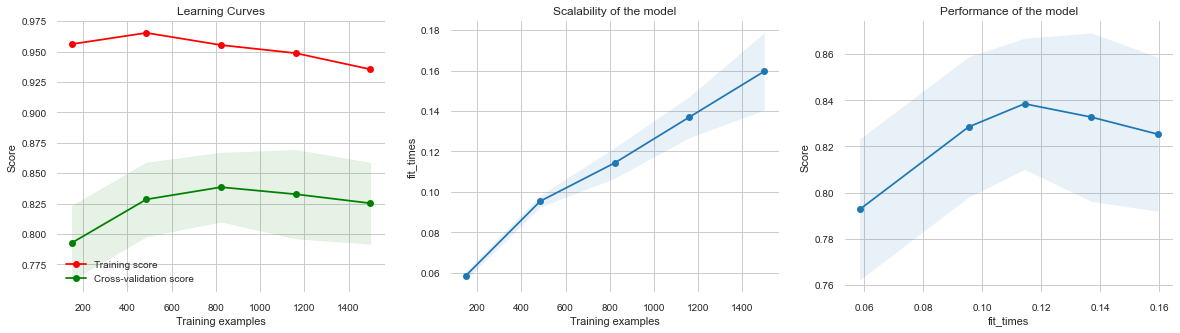

R2 for WF5 is 0.9337722272476011
Predictions for WF5 has been added to submission_df


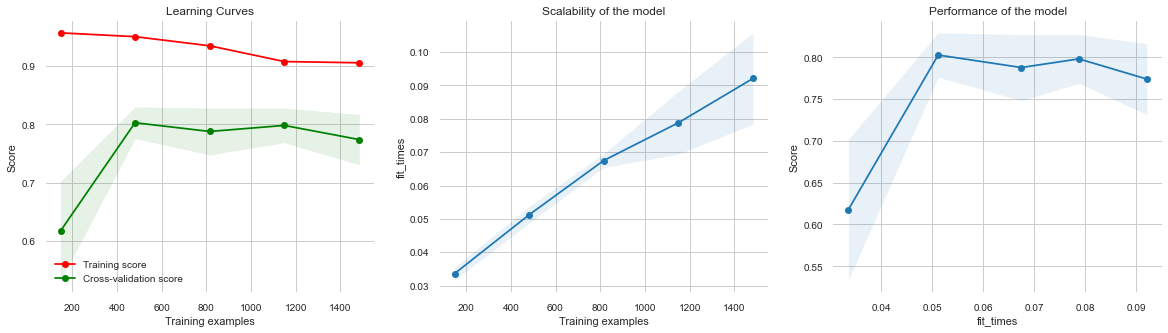

R2 for WF6 is 0.890801225243286
Predictions for WF6 has been added to submission_df


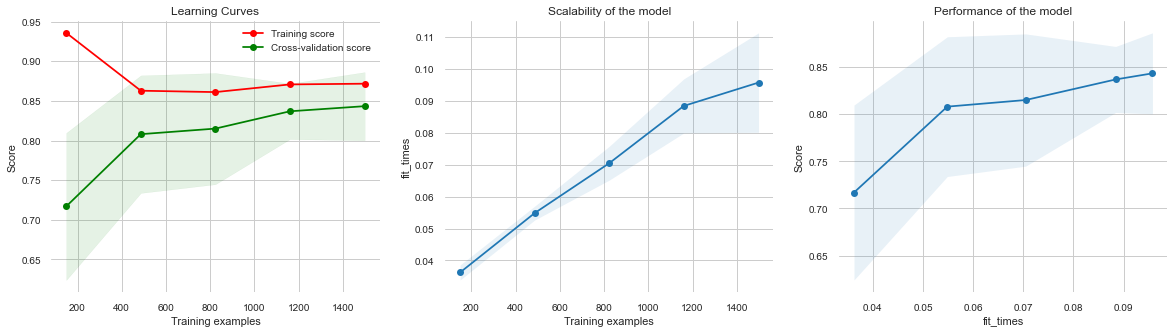

********************************************
Global score:  0.9200656633819397
********************************************


In [84]:
# Automatización de pre-procesado, modelización, validación y prediccion
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from src.functions import metric
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, learning_curve
from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestRegressor
import hdbscan
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# Lista de WFs
WF_lst = X_train['WF'].unique()

# lista para guardar los modelos, uno por WF
models = []
scores_list = []

# Data frame para guardar las predicciones (ID, Production)
submission_df = pd.DataFrame([], columns=['ID','Production']) 

for WF in WF_lst:
    # Creamos copia de los datos para no perder su formato inicial
    X_train_cpy = X_train.copy()
    Y_train_cpy = Y_train.copy()
    X_test_cpy = X_test.copy()

    # Selección de filas por WF
    X_train_cpy = X_train_cpy[X_train_cpy['WF'] == WF]
    X_test_cpy = X_test_cpy[X_test_cpy['WF'] == WF]

    # Identificador de observaciones
    ID_train = X_train_cpy['ID']
    ID_test = X_test_cpy['ID']

    # Seleccion de las filas de Y_train
    Y_train_cpy = Y_train_cpy['Production']
    Y_train_cpy = Y_train_cpy.loc[ID_train.values - 1]

    # Pre-procesado de los datos en bruto

    # We'll add new columns NWPX_<met_var> without missing values
    # new cols: NWP1_U, NWP1_V, NWP1_T, NWP2_U, NWP2_V, NWP3_U, NWP3_V, NWP3_T, NWP4_U, NWP4_V, NWP4_CLCT
    
    new_cols = ['NWP1_U','NWP1_V','NWP1_T','NWP2_U',
                'NWP2_V','NWP3_U','NWP3_V','NWP3_T',
                'NWP4_U','NWP4_V','NWP4_CLCT']

    def add_new_cols(new_cols, df):
        for col in new_cols:
            df[col] = np.nan    
            
    add_new_cols(new_cols, X_train_cpy)
    add_new_cols(new_cols, X_test_cpy)
    
    cols_train = X_train.columns[3:]
    cols_test = X_test.columns[3:-9]
    X_train_cpy = input_missing_values(X_train_cpy, cols_train)
    X_test_cpy = input_missing_values(X_test_cpy, cols_test)
    
    col_list = ['NWP2_U','NWP2_V','NWP3_U','NWP3_V','NWP3_T']
    X_train_cpy.index = X_train_cpy['Time']
    
    del X_train_cpy['Time']
        
    for var in col_list:
        X_train_cpy[var].interpolate(
            method='time', 
            inplace=True,
            limit=2,
            limit_direction='both'
        )

    
    X_train_cpy.reset_index(inplace=True)

    X_test_cpy.index = X_test_cpy['Time']
    
    del X_test_cpy['Time']
        
    for var in col_list:
        X_test_cpy[var].interpolate(
            method='time', 
            inplace=True,
            limit=100,
            limit_direction='both'
        )
    
        
    X_test_cpy.reset_index(inplace=True) 

    X_train_cpy['U'] = (X_train_cpy.NWP1_U + X_train_cpy.NWP2_U + X_train_cpy.NWP3_U + X_train_cpy.NWP4_U)/4
    X_train_cpy['V'] = (X_train_cpy.NWP1_V + X_train_cpy.NWP2_V + X_train_cpy.NWP3_V + X_train_cpy.NWP4_V)/4
    X_train_cpy['T'] = (X_train_cpy.NWP1_T + X_train_cpy.NWP3_T)/2
    X_train_cpy['CLCT'] = (X_train_cpy.NWP4_CLCT)
    
    X_test_cpy['U'] = (X_test_cpy.NWP1_U + X_test_cpy.NWP2_U + X_test_cpy.NWP3_U)/3
    X_test_cpy['V'] = (X_test_cpy.NWP1_V + X_test_cpy.NWP2_V + X_test_cpy.NWP3_V)/3
    X_test_cpy['T'] = (X_test_cpy.NWP1_T + X_test_cpy.NWP3_T)/2
    X_test_cpy['CLCT'] = (X_test_cpy.NWP4_CLCT)

    
    X_train_cpy = X_train_cpy[['ID','Time','U','V','T','CLCT']]
    X_test_cpy = X_test_cpy[['ID','Time','U','V','T','CLCT']]
    
    # Hay 11 valores perdidos en la columna CLCT en X_test_cpy. Los imputamos
    X_test_cpy['CLCT'].fillna(method='bfill', limit=11, inplace=True)
    
     ####### Limpiar outliers y valores anómalos #######
    
    # valores negativos en CLCT
    X_train_cpy.loc[X_train_cpy['CLCT'] < 0, 'CLCT'] = 0.0
    X_test_cpy.loc[X_test_cpy['CLCT'] < 0, 'CLCT'] = 0.0

    # añadir columna Production
    X_train_cpy['Production'] = Y_train_cpy.to_list()
    
    # calcular módulo velocidad del viento
    X_train_cpy['vel'] = X_train_cpy.apply(get_wind_velmod, axis=1)
    
    # formar matriz de datos 
    mm = PowerTransformer()

    X1 = mm.fit_transform(np.array(X_train_cpy['vel']).reshape(-1,1))
    X2 = mm.fit_transform(np.array(X_train_cpy['Production']).reshape(-1,1))
    X = np.concatenate((X1,X2), axis=1)
    
    # algoritmo para detección de outliers
    clusterer = hdbscan.HDBSCAN(min_cluster_size=20).fit(X)
    threshold = pd.Series(clusterer.outlier_scores_).quantile(0.96)
    outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
    
    # Eliminamos los registros outliers 
    X_train_cpy.drop(X_train_cpy.index[list(outliers)], inplace=True)
    
    # Eliminamos las observaciones corresp#ondientes de Y_train
    Y_train_cpy = Y_train_cpy.loc[X_train_cpy['ID'].values - 1]
    
    # Eliminamos las columnas 'vel' y 'Production'
    del X_train_cpy['vel']
    del X_train_cpy['Production']
    
    ###################################

    # Pre-procesado de los datos
    pre_process = ColumnTransformer(remainder = 'passthrough',
                                    transformers = [('drop_columns', 'drop', ['ID','Time','U','V','T',
                                                                             'month','hour','w_dir'])]
    )

    # definir pipeline
    prepare_data_pipeline = Pipeline(steps=[
        ('attr_adder', dtr.NewFeaturesAdder()), 
        ('pre_processing', pre_process)
    ])


    # aplicar pipeline
    X_train_pped = prepare_data_pipeline.fit_transform(X_train_cpy, Y_train_cpy)
    # print('Nº features antes de la seleccion: ', X_train_pped.shape[1])
    
    # seleccionar features más importantes mediante Random Forest
    #rf = RandomForestRegressor(random_state=42)
    #rf_reg = rf.fit(X_train_pped, Y_train_cpy)
    #sel = SelectFromModel(rf_reg, prefit=True, threshold='2*median')
    #X_train_pped = sel.transform(X_train_pped)
    
    # print('Nº features después de la seleccion: ', X_train_pped.shape[1])               


    # creamos nuestro scorer basado en el CAPE
    cape_scorer = make_scorer(metric.get_cape, greater_is_better=False)

    # Modelización: Random Forest
    # Entrenamiento del modelo mediante k-fold cross validation
    # Búsqueda de hiperparámetros mediante Gridsearch 
    
    param_grid = {   
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
    }
    
    tscv = TimeSeriesSplit(n_splits=5)
    xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror')
    grid_search_xgb = GridSearchCV(
        xgb_reg, 
        param_grid, 
        cv=tscv,
        scoring=cape_scorer,
        n_jobs=-1
    )
    
    grid_search_xgb.fit(X_train_pped, Y_train_cpy)
    
    reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = grid_search_xgb.best_params_['colsample_bytree'],
                           gamma = grid_search_xgb.best_params_['gamma'],
                           max_depth = grid_search_xgb.best_params_['max_depth'],
                           min_child_weight = grid_search_xgb.best_params_['min_child_weight'],
                           subsample = grid_search_xgb.best_params_['subsample'],
                           random_state=42)
                                       
    reg.fit(X_train_pped, Y_train_cpy)
    
    # evaluación sobre el conjunto de test
    X_test_pped = prepare_data_pipeline.transform(X_test_cpy)
    # X_test_pped = sel.transform(X_test_pped)
    predictions = reg.predict(X_test_pped)
    
    # generamos matriz de predicciones (ID,Production)
    pred_matrix = np.stack((np.array(ID_test).astype(int), predictions), axis=-1)
    df_pred = pd.DataFrame(data=pred_matrix, columns=['ID','Production'])

    # añadimos las predicciones al dataframe final que contendrá las de todas las WF
    submission_df = submission_df.append(df_pred, ignore_index=True) 
    print('R2 for {} is {}'.format(WF, reg.score(X_train_pped, Y_train_cpy)))
    print('Predictions for {} has been added to submission_df'.format(WF))
    
    scores_list.append(reg.score(X_train_pped, Y_train_cpy))

    title = "Learning Curves"
    cv = TimeSeriesSplit(n_splits=3)

    estimator = reg
    plot_learning_curve(estimator, title, X_train_pped, Y_train_cpy, cv=cv, n_jobs=-1)

    plt.show()
    
global_score = np.mean(scores_list)

print('********************************************')
print('Global score: ', global_score)
print('********************************************')


# generamos fichero csv para el submission
submission_df.to_csv("../../TFM/models/submission_xgb2.csv", index=False, sep=",")

In [54]:
Y_train_cpy.describe()

count    5989.000000
mean        1.193359
std         1.242188
min         0.000000
25%         0.109985
50%         0.729980
75%         2.009766
max         4.000000
Name: Production, dtype: float64

## Prueba 5: Random Forest con validación Randomized Search 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Automatización de pre-procesado, modelización, validación y prediccion
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from src.functions import metric
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib

# Lista de WFs
WF_lst = X_train['WF'].unique()

# lista para guardar los modelos, uno por WF
models = []

# Data frame para guardar las predicciones (ID, Production)
submission_df = pd.DataFrame([], columns=['ID','Production']) 

for WF in WF_lst:
    # Creamos copia de los datos para no perder su formato inicial
    X_train_cpy = X_train.copy()
    Y_train_cpy = Y_train.copy()
    X_test_cpy = X_test.copy()

    # Selección de filas por WF
    X_train_cpy = X_train_cpy[X_train_cpy['WF'] == WF]
    X_test_cpy = X_test_cpy[X_test_cpy['WF'] == WF]

    # Identificador de observaciones
    ID_train = X_train_cpy['ID']
    ID_test = X_test_cpy['ID']

    # Seleccion de las filas de Y_train
    Y_train_cpy = Y_train_cpy['Production']
    Y_train_cpy = Y_train_cpy.loc[ID_train.values - 1]

    # Pre-procesado de los datos en bruto

    # We'll add new columns NWPX_<met_var> without missing values
    # new cols: NWP1_U, NWP1_V, NWP1_T, NWP2_U, NWP2_V, NWP3_U, NWP3_V, NWP3_T, NWP4_U, NWP4_V, NWP4_CLCT
    
    new_cols = ['NWP1_U','NWP1_V','NWP1_T','NWP2_U',
                'NWP2_V','NWP3_U','NWP3_V','NWP3_T',
                'NWP4_U','NWP4_V','NWP4_CLCT']

    def add_new_cols(new_cols, df):
        for col in new_cols:
            df[col] = np.nan    
            
    add_new_cols(new_cols, X_train_cpy)
    add_new_cols(new_cols, X_test_cpy)
    
    cols_train = X_train.columns[3:]
    cols_test = X_test.columns[3:-9]
    X_train_cpy = input_missing_values(X_train_cpy, cols_train)
    X_test_cpy = input_missing_values(X_test_cpy, cols_test)
    
    col_list = ['NWP2_U','NWP2_V','NWP3_U','NWP3_V','NWP3_T']
    X_train_cpy.index = X_train_cpy['Time']
    
    del X_train_cpy['Time']
        
    for var in col_list:
        X_train_cpy[var].interpolate(
            method='time', 
            inplace=True,
            limit=2,
            limit_direction='both'
        )

    
    X_train_cpy.reset_index(inplace=True)

    X_test_cpy.index = X_test_cpy['Time']
    
    del X_test_cpy['Time']
        
    for var in col_list:
        X_test_cpy[var].interpolate(
            method='time', 
            inplace=True,
            limit=100,
            limit_direction='both'
        )
    
        
    X_test_cpy.reset_index(inplace=True) 

    X_train_cpy['U'] = (X_train_cpy.NWP1_U + X_train_cpy.NWP2_U + X_train_cpy.NWP3_U + X_train_cpy.NWP4_U)/4
    X_train_cpy['V'] = (X_train_cpy.NWP1_V + X_train_cpy.NWP2_V + X_train_cpy.NWP3_V + X_train_cpy.NWP4_V)/4
    X_train_cpy['T'] = (X_train_cpy.NWP1_T + X_train_cpy.NWP3_T)/2
    X_train_cpy['CLCT'] = (X_train_cpy.NWP4_CLCT)
    X_train_cpy['T2'] = np.sqrt(X_train_cpy['T'])
    
    X_test_cpy['U'] = (X_test_cpy.NWP1_U + X_test_cpy.NWP2_U + X_test_cpy.NWP3_U)/3
    X_test_cpy['V'] = (X_test_cpy.NWP1_V + X_test_cpy.NWP2_V + X_test_cpy.NWP3_V)/3
    X_test_cpy['T'] = (X_test_cpy.NWP1_T + X_test_cpy.NWP3_T)/2
    X_test_cpy['CLCT'] = (X_test_cpy.NWP4_CLCT)
    X_test_cpy['T2'] = np.sqrt(X_test_cpy['T'])

    
    X_train_cpy = X_train_cpy[['ID','Time','U','V','T','CLCT','T2']]
    X_test_cpy = X_test_cpy[['ID','Time','U','V','T','CLCT','T2']]
    
    # Hay 11 valores perdidos en la columna CLCT en X_test_cpy. Los imputamos con la moda
    X_test_cpy.fillna(method='bfill', limit=11, inplace=True)
    
    ####### Limpiar outliers #######
    
    # añadir columna Production
    X_train_cpy['Production'] = Y_train_cpy.to_list()
    
    # calcular módulo velocidad del viento
    X_train_cpy['vel'] = X_train_cpy.apply(get_wind_velmod, axis=1)
    
    # formar matriz de datos 
    X1 = X_train_cpy['vel'].values.reshape(-1,1)
    X2 = X_train_cpy['Production'].values.reshape(-1,1)
    X = np.concatenate((X1,X2), axis=1)
    
    # Definir el clasificador de outliers
    clf = OneClassSVM(nu=0.17, gamma=0.06)
    clf.fit(X)
    
    # Predección de outlier o inlier para cada punto
    y_pred = clf.predict(X)
    
    # Añadirmos la columna 'oulier' con la predicción 
    X_train_cpy['outlier'] = y_pred.tolist()
    
    # Eliminamos los registros outliers 
    X_train_cpy = X_train_cpy[X_train_cpy['outlier'] != -1]
    
    # Eliminamos las observaciones correspondientes de Y_train
    Y_train_cpy = Y_train_cpy.loc[X_train_cpy['ID'].values - 1]
    
    # Eliminamos las columnas 'vel', 'outlier' y 'Production'
    del X_train_cpy['vel']
    del X_train_cpy['outlier']
    del X_train_cpy['Production']
    
    ###################################

    # Pre-procesado de los datos
    pre_process = ColumnTransformer(remainder = 'passthrough',
                                    transformers = [('drop_columns', 'drop', 
                                                     ['ID','Time','U','V','T2'])]
    )

    # definir pipeline
    prepare_data_pipeline = Pipeline(steps=[
        ('attr_adder', dtr.NewFeaturesAdder(add_w_shear=False, add_time_feat=False)), 
        ('pre_processing', pre_process),
        ('std_scaler', StandardScaler())
    ])
    # aplciar pipeline
    X_train_pped = prepare_data_pipeline.fit_transform(X_train_cpy)

    # creamos nuestro scorer basado en el CAPE
    cape_scorer = make_scorer(metric.get_cape, greater_is_better=False)

    # Modelización: Random Forest
    # Entrenamiento del modelo mediante k-fold cross validation
    # Búsqueda de hiperparámetros mediante Randomized Search 

    forest_reg = RandomForestRegressor()

    rf_random = RandomizedSearchCV(
        estimator = forest_reg, 
        param_distributions = random_grid, 
        n_iter = 100, 
        cv = 5, 
        random_state=42, 
        scoring = cape_scorer,
        n_jobs = -1
    )

    rf_random.fit(X_train_pped, Y_train_cpy)
    final_model = rf_random.best_estimator_

    # guardamos modelo
    models.append(joblib.dump(final_model, WF + 'rfrand'))

    # evaluación sobre el conjunto de test
    X_test_pped = prepare_data_pipeline.transform(X_test_cpy)
    predictions = final_model.predict(X_test_pped)

    # generamos matriz de predicciones (ID,Production)
    pred_matrix = np.stack((np.array(ID_test).astype(int), predictions), axis=-1)
    df_pred = pd.DataFrame(data=pred_matrix, columns=['ID','Production'])

    # añadimos las predicciones al dataframe final que contendrá las de todas las WF
    submission_df = submission_df.append(df_pred, ignore_index=True)  
    print('Best score for {}: {}'.format(WF, -rf_random.best_score_))
    print('Predictions for {} has been added to submission_df'.format(WF))
    print('--------')


# generamos fichero csv para el submission
submission_df.to_csv("./Data/submission_rfrand.csv", index=False, sep=",") 

## Prueba 6: Regresión con Elastic Net (Ridge + Lasso)

In [47]:
# Automatización de pre-procesado, modelización, validación y prediccion
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from src.functions import metric
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.externals import joblib
import re
from collections import OrderedDict


# Lista de WFs
WF_lst = X_train['WF'].unique()

# lista para guardar los modelos, uno por WF
# models = []

# Data frame para guardar las predicciones (ID, Production)
submission_df = pd.DataFrame([], columns=['ID','Production']) 

for WF in WF_lst:
    # Creamos copia de los datos para no perder su formato inicial
    X_train_cpy = X_train.copy()
    Y_train_cpy = Y_train.copy()
    X_test_cpy = X_test.copy()

    # Selección de filas por WF
    X_train_cpy = X_train_cpy[X_train_cpy['WF'] == WF]
    X_test_cpy = X_test_cpy[X_test_cpy['WF'] == WF]

    # Identificador de observaciones
    ID_train = X_train_cpy['ID']
    ID_test = X_test_cpy['ID']

    # Seleccion de las filas de Y_train
    Y_train_cpy = Y_train_cpy['Production']
    Y_train_cpy = Y_train_cpy.loc[ID_train.values - 1]

    # Pre-procesado de los datos en bruto

    # We'll add new columns NWPX_<met_var> without missing values
    # new cols: NWP1_U, NWP1_V, NWP1_T, NWP2_U, NWP2_V, NWP3_U, NWP3_V, NWP3_T, NWP4_U, NWP4_V, NWP4_CLCT
    
    new_cols = ['NWP1_U','NWP1_V','NWP1_T','NWP2_U',
                'NWP2_V','NWP3_U','NWP3_V','NWP3_T',
                'NWP4_U','NWP4_V','NWP4_CLCT']

    def add_new_cols(new_cols, df):
        for col in new_cols:
            df[col] = np.nan    
            
    add_new_cols(new_cols, X_train_cpy)
    add_new_cols(new_cols, X_test_cpy)
    
    cols_train = X_train.columns[3:]
    cols_test = X_test.columns[3:-9]
    X_train_cpy = input_missing_values(X_train_cpy, cols_train)
    X_test_cpy = input_missing_values(X_test_cpy, cols_test)
    
    col_list = ['NWP2_U','NWP2_V','NWP3_U','NWP3_V','NWP3_T']
    X_train_cpy.index = X_train_cpy['Time']
    
    del X_train_cpy['Time']
        
    for var in col_list:
        X_train_cpy[var].interpolate(
            method='time', 
            inplace=True,
            limit=2,
            limit_direction='both'
        )

    
    X_train_cpy.reset_index(inplace=True)

    X_test_cpy.index = X_test_cpy['Time']
    
    del X_test_cpy['Time']
        
    for var in col_list:
        X_test_cpy[var].interpolate(
            method='time', 
            inplace=True,
            limit=100,
            limit_direction='both'
        )
    
        
    X_test_cpy.reset_index(inplace=True) 

    X_train_cpy['U'] = X_train_cpy.NWP1_U
    X_train_cpy['V'] = X_train_cpy.NWP1_V
    X_train_cpy['T'] = X_train_cpy.NWP3_T
    X_train_cpy['CLCT'] = X_train_cpy.NWP4_CLCT
    
    X_test_cpy['U'] = X_test_cpy.NWP1_U
    X_test_cpy['V'] = X_test_cpy.NWP1_V
    X_test_cpy['T'] = X_test_cpy.NWP3_T
    X_test_cpy['CLCT'] = X_test_cpy.NWP4_CLCT
 
    X_train_cpy = X_train_cpy[['ID','Time','U','V','T','CLCT']]
    X_test_cpy = X_test_cpy[['ID','Time','U','V','T','CLCT']]
    
    # Hay 11 valores perdidos en la columna CLCT en X_test_cpy. Los imputamos
    X_test_cpy.fillna(method='bfill', limit=11, inplace=True)

    ####### Limpiar outliers #######
    # Negative values in CLCT
    X_train_cpy.loc[X_train_cpy['CLCT'] < 0, 'CLCT'] = 0.0
    X_test_cpy.loc[X_test_cpy['CLCT'] < 0, 'CLCT'] = 0.0
    
    # Locating and removing outliers based on wind power curve
    # Add 'Production' column
    X_train_cpy['Production'] = Y_train_cpy.to_list()
    
    # Calculate wind velocity module
    X_train_cpy['vel'] = X_train_cpy.apply(dtr.get_wind_velmod, axis=1)
    
    # Build data matrix
    mm = PowerTransformer(method='yeo-johnson', standardize=True)
    
    X1 = mm.fit_transform(X_train_cpy['vel'].values.reshape(-1,1))
    X2 = mm.fit_transform(X_train_cpy['Production'].values.reshape(-1,1))
    X = np.concatenate((X1,X2), axis=1)
    
    # Using DBSCAN to find outliers
    from sklearn.cluster import DBSCAN
    outlier_detection = DBSCAN(
        eps = 0.1,
        metric="l1",
        min_samples = 10,
        n_jobs = -1)
    
    clusters = outlier_detection.fit_predict(X)
    outliers = np.where(clusters == -1)[0]

    # Deleting columns 'vel' and 'Production'
    del X_train_cpy['vel']
    del X_train_cpy['Production']
    ###################################

    pre_process = ColumnTransformer(remainder = 'passthrough',
                                    transformers = [('drop_columns', 'drop', 
                                                     ['ID','Time','U','V',
                                                      'month_sin','month_cos',
                                                      'w_dir','month','hour'
                                                      ])]
    )
    
    prepare_data_pipeline = Pipeline(steps=[
        ('attr_adder', dtr.NewFeaturesAdder(add_cycl_feat=True, add_time_feat=True)), 
        ('pre_processing', pre_process),
        ('power_transf', PowerTransformer())
    ])

    # aplicar pipeline
    X_train_pped = prepare_data_pipeline.fit_transform(X_train_cpy)
    
    # Deleting outlier related observations
    X_train_pped = np.delete(X_train_pped, tuple(outliers), axis=0)

    # Deleting the corresponding observations in y_train
    Y_train_cpy = np.delete(Y_train_cpy.to_numpy(), list(outliers))
    
    # creamos nuestro scorer basado en el CAPE
    cape_scorer = make_scorer(metric.get_cape, greater_is_better=False)

    # Modelización: Regresión polinomial con regularización Elastic Net
    # Entrenamiento del modelo mediante k-fold cross validation
    # Búsqueda de hiperparámetros mediante Gridsearch 
    
    poly_features = PolynomialFeatures(degree=3, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train_pped)
    
    param_grid = [{
        'alpha'     : np.logspace(-3, -2, 1, 2, 3),
        'l1_ratio'  : [0.00, 0.25, 0.50, 0.75, 1.0],
        'tol'       : [0.00001, 0.0001, 0.001]
    }]
    
                                               
    eNet = ElasticNet(selection='random')
    grid_search = GridSearchCV(
        eNet, 
        param_grid, 
        cv = TimeSeriesSplit(n_splits=7),
        scoring=cape_scorer,
        n_jobs=-1
    )

    grid_search.fit(X_train_poly, Y_train_cpy)
    
    # Calculate cross validation scores
    cvres = grid_search.cv_results_
    print('Best CV score:', -grid_search.best_score_)

    # Re-training without CV, using the best param#eters obtained by CV
    eNet2 = ElasticNet(selection='random',
                       alpha=grid_search.best_params_['alpha'],
                       l1_ratio=grid_search.best_params_['l1_ratio'],
                       tol=grid_search.best_params_['tol']
                      )
    
    
    ttreg = TransformedTargetRegressor(regressor=eNet2, 
                                       transformer=PowerTransformer(), 
                                       check_inverse=False)
    
    ttreg.fit(X_train_poly, Y_train_cpy)
            
    # evaluación sobre el conjunto de test
    X_test_pped = prepare_data_pipeline.transform(X_test_cpy)
    X_test_poly = poly_features.fit_transform(X_test_pped)
    predictions = ttreg.predict(X_test_poly)
    
    # build prediction matrix (ID,Production)
    pred_matrix = np.stack((np.array(ID_test).astype(int), predictions), axis=-1)
    df_pred = pd.DataFrame(data=pred_matrix, columns=['ID','Production'])
    
    # añadimos las predicciones al dataframe final que contendrá las de todas las WF
    submission_df = submission_df.append(df_pred, ignore_index=True) 
    # print('R^2 for {} is {}'.format(WF, ttreg.score(X_train_poly, Y_train_cpy)))
    print('Predictions for {} has been added to submission_df'.format(WF))
    print('---------------')

# generamos fichero csv para el submission
submission_df.to_csv("../../TFM/models/elasticNet_2.csv", index=False, sep=",") 

Best CV score: 40.57091479334


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning:

overflow encountered in reduce



Predictions for WF1 has been added to submission_df
---------------
Best CV score: 31.02765964089699


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning:

overflow encountered in reduce



Predictions for WF2 has been added to submission_df
---------------
Best CV score: 31.560895962212502


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning:

overflow encountered in reduce



Predictions for WF3 has been added to submission_df
---------------
Best CV score: 29.437008415740955


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning:

overflow encountered in reduce



Predictions for WF4 has been added to submission_df
---------------
Best CV score: 36.50560140439283


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning:

overflow encountered in reduce



Predictions for WF5 has been added to submission_df
---------------
Best CV score: 32.77197622382412


C:\Users\Quark\.conda\envs\TFM-env\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning:

overflow encountered in reduce



Predictions for WF6 has been added to submission_df
---------------


In [44]:
X_train_pped.shape

(5770, 5)

## Prueba 7: LassoCV

In [ ]:
# Automatización de pre-procesado, modelización, validación y prediccion
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from src.functions import metric
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model as lm
from sklearn.linear_model import LassoCV

# Lista de WFs
WF_lst = X_train['WF'].unique()

# lista para guardar los modelos, uno por WF
models = []

# Data frame para guardar las predicciones (ID, Production)
submission_df = pd.DataFrame([], columns=['ID','Production']) 



for WF in WF_lst:
    # Creamos copia de los datos para no perder su formato inicial
    X_train_cpy = X_train.copy()
    Y_train_cpy = Y_train.copy()
    X_test_cpy = X_test.copy()

    # Selección de filas por WF
    X_train_cpy = X_train_cpy[X_train_cpy['WF'] == WF]
    X_test_cpy = X_test_cpy[X_test_cpy['WF'] == WF]

    # Identificador de observaciones
    ID_train = X_train_cpy['ID']
    ID_test = X_test_cpy['ID']

    # Seleccion de las filas de Y_train
    Y_train_cpy = Y_train_cpy['Production']
    Y_train_cpy = Y_train_cpy.loc[ID_train.values - 1]

    # Pre-procesado de los datos en bruto

    # We'll add new columns NWPX_<met_var> without missing values
    # new cols: NWP1_U, NWP1_V, NWP1_T, NWP2_U, NWP2_V, NWP3_U, NWP3_V, NWP3_T, NWP4_U, NWP4_V, NWP4_CLCT
    
    new_cols = ['NWP1_U','NWP1_V','NWP1_T','NWP2_U',
                'NWP2_V','NWP3_U','NWP3_V','NWP3_T',
                'NWP4_U','NWP4_V','NWP4_CLCT']

    def add_new_cols(new_cols, df):
        for col in new_cols:
            df[col] = np.nan    
            
    add_new_cols(new_cols, X_train_cpy)
    add_new_cols(new_cols, X_test_cpy)
    
    cols_train = X_train_cpy.columns[3:-11]
    cols_test = X_test_cpy.columns[3:-11]
    X_train_cpy = input_missing_values(X_train_cpy, cols_train)
    X_test_cpy = input_missing_values(X_test_cpy, cols_train)
    
    col_list = ['NWP2_U','NWP2_V','NWP3_U','NWP3_V','NWP3_T']
    X_train_cpy.index = X_train_cpy['Time']
    
    del X_train_cpy['Time']
        
    for var in col_list:
        X_train_cpy[var].interpolate(
            method='time', 
            inplace=True,
            limit=2,
            limit_direction='both'
        )

    
    X_train_cpy.reset_index(inplace=True)

    X_test_cpy.index = X_test_cpy['Time']
    
    del X_test_cpy['Time']
        
    for var in col_list:
        X_test_cpy[var].interpolate(
            method='time', 
            inplace=True,
            limit=100,
            limit_direction='both'
        )
    
        
    X_test_cpy.reset_index(inplace=True) 

    X_train_cpy['U'] = (X_train_cpy.NWP1_U + X_train_cpy.NWP2_U + X_train_cpy.NWP3_U + X_train_cpy.NWP4_U)/4
    X_train_cpy['V'] = (X_train_cpy.NWP1_V + X_train_cpy.NWP2_V + X_train_cpy.NWP3_V + X_train_cpy.NWP4_V)/4
    X_train_cpy['T'] = (X_train_cpy.NWP1_T + X_train_cpy.NWP3_T)/2
    X_train_cpy['CLCT'] = (X_train_cpy.NWP4_CLCT)
    X_train_cpy['inv_T'] = 1/(X_train_cpy['T'])
    
    X_test_cpy['U'] = (X_test_cpy.NWP1_U + X_test_cpy.NWP2_U + X_test_cpy.NWP3_U)/3
    X_test_cpy['V'] = (X_test_cpy.NWP1_V + X_test_cpy.NWP2_V + X_test_cpy.NWP3_V)/3
    X_test_cpy['T'] = (X_test_cpy.NWP1_T + X_test_cpy.NWP3_T)/2
    X_test_cpy['CLCT'] = (X_test_cpy.NWP4_CLCT)
    X_test_cpy['inv_T'] = 1/(X_test_cpy['T'])
    
    X_train_cpy = X_train_cpy[['Time','U','V','T','CLCT','inv_T']]
    X_test_cpy = X_test_cpy[['Time','U','V','T','CLCT', 'inv_T']]

    
    ## Limpieza de datos: imputar valores perdidos en X_
    #only_na = X_test_cpy[~X_test_cpy.ID.isin(X_test_cpy.dropna().ID)]
    #X_test_cpy.dropna(inplace=True)
    #Y_train_cpy.drop(labels=only_na.index, axis=0, inplace=True)
    #X_train_cpy.drop(labels=only_na.index, axis=0, inplace=True)

    # Pre-procesado de los datos
    pre_process = ColumnTransformer(remainder = 'passthrough',
                                    transformers = [('drop_columns', 'drop', 
                                                     ['Time','U','V','T'])]
    )

    # definir pipeline
    prepare_data_pipeline = Pipeline(steps=[
        ('attr_adder', dtr.DerivedAttributesAdder(add_time_feat=False, add_cyclic_feat=False)), 
        ('pre_processing', pre_process),
        ('std_scaler', StandardScaler())
    ])

    # aplicar pipeline
    X_train_pped = prepare_data_pipeline.fit_transform(X_train_cpy)


    # creamos nuestro scorer basado en el CAPE
    cape_scorer = make_scorer(metric.get_cape, greater_is_better=False)

    # Modelización: Regresión polinomial utilizando CV con regularización tipo Ride
    poly_features = PolynomialFeatures(degree=3, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train_pped)
    
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    lasso_reg = lm.Lasso()

    grid_search = GridSearchCV(
        lasso_reg, 
        param_grid, 
        cv=7,
        scoring=cape_scorer,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_poly, Y_train_cpy)
    final_model = grid_search.best_estimator_
    
    # guardamos modelo
    models.append(joblib.dump(final_model, WF + '_lasso'))

    # evaluación sobre el conjunto de test
    X_test_pped = prepare_data_pipeline.transform(X_test_cpy)
    X_test_poly = poly_features.fit_transform(X_test_pped)
    predictions = final_model.predict(X_test_poly)
    
    # generamos matriz de predicciones (ID,Production)
    pred_matrix = np.stack((np.array(ID_test).astype(int), predictions), axis=-1)
    df_pred = pd.DataFrame(data=pred_matrix, columns=['ID','Production'])

    # añadimos las predicciones al dataframe final que contendrá las de todas las WF
    submission_df = submission_df.append(df_pred, ignore_index=True) 
    print('CAPE for {} is {}'.format(WF, -grid_search.best_score_))
    print('Predictions for {} has been added to submission_df'.format(WF))

# generamos fichero csv para el submission
submission_df.to_csv("../../TFM/models/submission_lasso.csv", index=False, sep=",") 

## Prueba 8: Regresión robusta con RANSAC

In [ ]:
# Automatización de pre-procesado, modelización, validación y prediccion
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from src.functions import metric
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor

# Lista de WFs
WF_lst = X_train['WF'].unique()

# lista para guardar los modelos, uno por WF
models = []

# Data frame para guardar las predicciones (ID, Production)
submission_df = pd.DataFrame([], columns=['ID','Production']) 

for WF in WF_lst:
    # Creamos copia de los datos para no perder su formato inicial
    X_train_cpy = X_train.copy()
    Y_train_cpy = Y_train.copy()
    X_test_cpy = X_test.copy()

    # Selección de filas por WF
    X_train_cpy = X_train_cpy[X_train_cpy['WF'] == WF]
    X_test_cpy = X_test_cpy[X_test_cpy['WF'] == WF]

    # Identificador de observaciones
    ID_train = X_train_cpy['ID']
    ID_test = X_test_cpy['ID']

    # Seleccion de las filas de Y_train
    Y_train_cpy = Y_train_cpy['Production']
    Y_train_cpy = Y_train_cpy.loc[ID_train.values - 1]

    # Pre-procesado de los datos en bruto
    X_train_cpy = X_train_cpy[['Time','NWP1_00h_D-1_U','NWP1_00h_D-1_V','NWP1_00h_D-1_T']]
    X_train_cpy.rename(
        columns={"Time": "time", "NWP1_00h_D-1_U": "U", "NWP1_00h_D-1_V": "V", "NWP1_00h_D-1_T":"T"}, 
        inplace=True)

    X_test_cpy = X_test_cpy[['Time','NWP1_00h_D-1_U','NWP1_00h_D-1_V','NWP1_00h_D-1_T']]
    X_test_cpy.rename(
        columns={"Time": "time", "NWP1_00h_D-1_U": "U", "NWP1_00h_D-1_V": "V", "NWP1_00h_D-1_T":"T"}, 
        inplace=True)

    # Limpieza de datos: eliminar valores perdidos
    only_na = X_train_cpy[~X_train_cpy.index.isin(X_train_cpy.dropna().index)]
    X_train_cpy.dropna(inplace=True)
    Y_train_cpy.drop(labels=only_na.index, axis=0, inplace=True)

    X_test_cpy.dropna(inplace=True)

    # Pre-procesado de los datos
    pre_process = ColumnTransformer(remainder = 'passthrough',
                                    transformers = [('drop_columns', 'drop', ['time','U','V','T','w_dir'])]
    )

    # definir pipeline
    prepare_data_pipeline = Pipeline(steps=[
        ('attr_adder', dtr.DerivedAttributesAdder(add_time_feat=False)), 
        ('pre_processing', pre_process),
        ('std_scaler', StandardScaler())
    ])

    # aplicar pipeline
    X_train_pped = prepare_data_pipeline.fit_transform(X_train_cpy)

    # creamos nuestro scorer basado en el CAPE
    cape_scorer = make_scorer(metric.get_cape, greater_is_better=False)

    # Modelización: Regresión Robusta utilizando RANSAC
    poly_features = PolynomialFeatures(degree=3, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train_pped)
    
    ransac = RANSACRegressor(LinearRegression(), loss='absolute_loss')
    param_grid = [
        {
            'max_trials': [100, 1000, 10000],
            'min_samples': [10, 30, 50],
        }
    ]
    
    grid_search_ransac = GridSearchCV(
        ransac, 
        param_grid, 
        cv=5,
        scoring=cape_scorer
    )

    grid_search_ransac.fit(X_train_poly, Y_train_cpy)
    final_model = grid_search_ransac.best_estimator_
    
    # guardamos modelo
    models.append(joblib.dump(final_model, WF + '_ransac'))

    # evaluación sobre el conjunto de test
    X_test_pped = prepare_data_pipeline.transform(X_test_cpy)
    X_test_poly = poly_features.fit_transform(X_test_pped)
    predictions = final_model.predict(X_test_poly)
    
    # generamos matriz de predicciones (ID,Production)
    pred_matrix = np.stack((np.array(ID_test).astype(int), predictions), axis=-1)
    df_pred = pd.DataFrame(data=pred_matrix, columns=['ID','Production'])

    # añadimos las predicciones al dataframe final que contendrá las de todas las WF
    submission_df = submission_df.append(df_pred, ignore_index=True) 
    print('Predictions for {} has been added to submission_df'.format(WF))
    print('CAPE for {} is {}'.format(WF, -grid_search_ransac.best_score_))

# generamos fichero csv para el submission
submission_df.to_csv("./Data/submission_ransac.csv", index=False, sep=",") 

## Ejemplo 10: MARS

R2 for WF1 is 0.7530717987476954
Predictions for WF1 has been added to submission_df


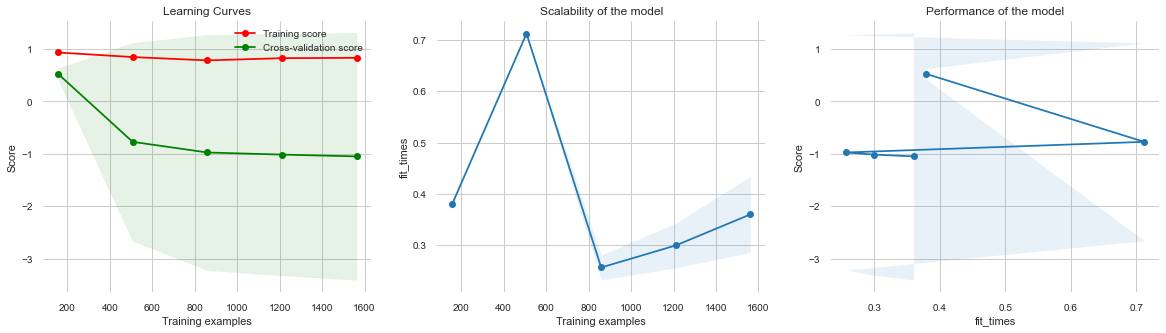

R2 for WF2 is 0.827258630768987
Predictions for WF2 has been added to submission_df


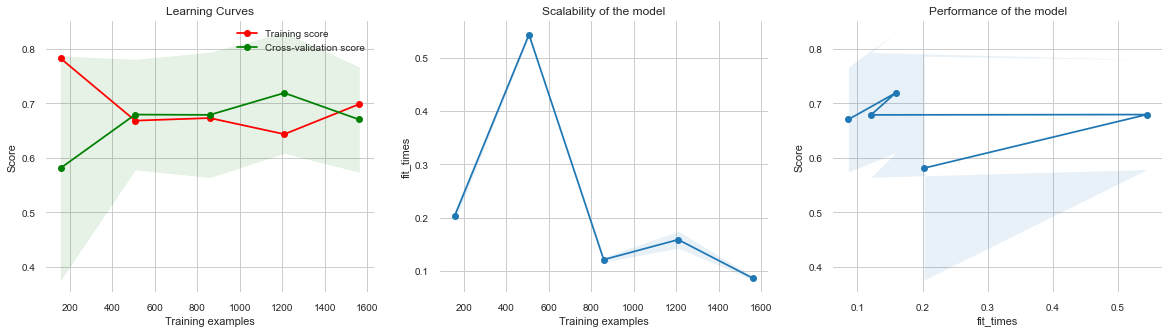

R2 for WF3 is 0.7916922228374152
Predictions for WF3 has been added to submission_df


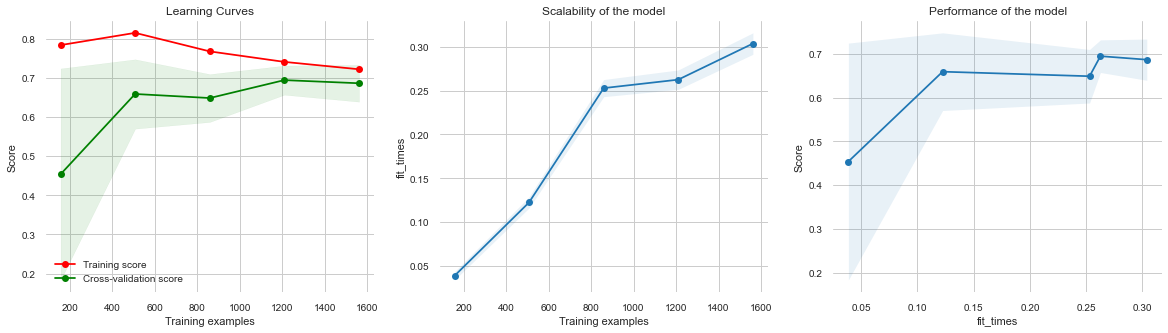

R2 for WF4 is 0.8474368880820433
Predictions for WF4 has been added to submission_df


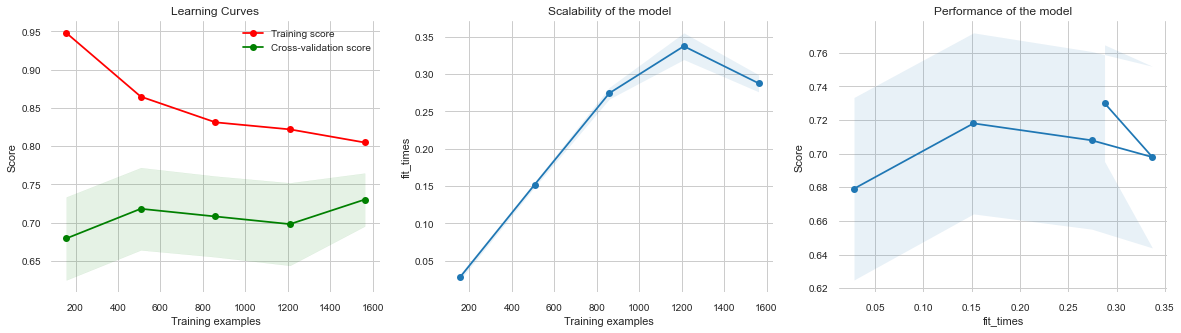

R2 for WF5 is 0.8427772735966716
Predictions for WF5 has been added to submission_df


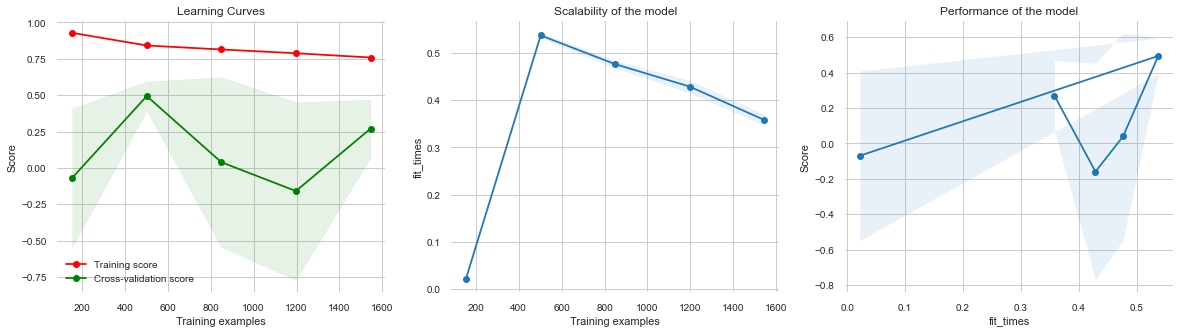

R2 for WF6 is 0.805361993304602
Predictions for WF6 has been added to submission_df


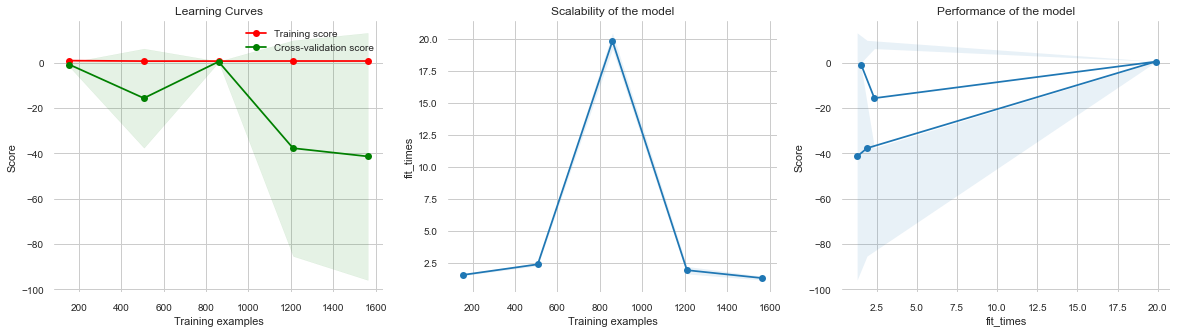

********************************************
Global score:  0.811266467889569
********************************************


In [9]:
# Automatización de pre-procesado, modelización, validación y prediccion
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from src.functions import metric
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model as lm
from pyearth import Earth
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
np.warnings.filterwarnings('ignore')
import hdbscan

# Lista de WFs
WF_lst = X_train['WF'].unique()

# lista para guardar los modelos, uno por WF
models = []
scores_list = []

# Data frame para guardar las predicciones (ID, Production)
submission_df = pd.DataFrame([], columns=['ID','Production']) 

for WF in WF_lst:
    # Creamos copia de los datos para no perder su formato inicial
    X_train_cpy = X_train.copy()
    Y_train_cpy = Y_train.copy()
    X_test_cpy = X_test.copy()

    # Selección de filas por WF
    X_train_cpy = X_train_cpy[X_train_cpy['WF'] == WF]
    X_test_cpy = X_test_cpy[X_test_cpy['WF'] == WF]

    # Identificador de observaciones
    ID_train = X_train_cpy['ID']
    ID_test = X_test_cpy['ID']

    # Seleccion de las filas de Y_train
    Y_train_cpy = Y_train_cpy['Production']
    Y_train_cpy = Y_train_cpy.loc[ID_train.values - 1]

    # Pre-procesado de los datos en bruto

    # We'll add new columns NWPX_<met_var> without missing values
    # new cols: NWP1_U, NWP1_V, NWP1_T, NWP2_U, NWP2_V, NWP3_U, NWP3_V, NWP3_T, NWP4_U, NWP4_V, NWP4_CLCT
    
    new_cols = ['NWP1_U','NWP1_V','NWP1_T','NWP2_U',
                'NWP2_V','NWP3_U','NWP3_V','NWP3_T',
                'NWP4_U','NWP4_V','NWP4_CLCT']

    def add_new_cols(new_cols, df):
        for col in new_cols:
            df[col] = np.nan    
            
    add_new_cols(new_cols, X_train_cpy)
    add_new_cols(new_cols, X_test_cpy)
    
    cols_train = X_train.columns[3:]
    cols_test = X_test.columns[3:-9]
    X_train_cpy = input_missing_values(X_train_cpy, cols_train)
    X_test_cpy = input_missing_values(X_test_cpy, cols_test)
    
    col_list = ['NWP2_U','NWP2_V','NWP3_U','NWP3_V','NWP3_T']
    X_train_cpy.index = X_train_cpy['Time']
    
    del X_train_cpy['Time']
        
    for var in col_list:
        X_train_cpy[var].interpolate(
            method='time', 
            inplace=True,
            limit=2,
            limit_direction='both'
        )

    
    X_train_cpy.reset_index(inplace=True)

    X_test_cpy.index = X_test_cpy['Time']
    
    del X_test_cpy['Time']
        
    for var in col_list:
        X_test_cpy[var].interpolate(
            method='time', 
            inplace=True,
            limit=100,
            limit_direction='both'
        )
    
        
    X_test_cpy.reset_index(inplace=True) 

    X_train_cpy['U'] = X_train_cpy.NWP1_U
    X_train_cpy['V'] = X_train_cpy.NWP1_V
    X_train_cpy['T'] = X_train_cpy.NWP3_T
    X_train_cpy['CLCT'] = X_train_cpy.NWP4_CLCT
    
    X_test_cpy['U'] = X_test_cpy.NWP1_U
    X_test_cpy['V'] = X_test_cpy.NWP1_V
    X_test_cpy['T'] = X_test_cpy.NWP3_T
    X_test_cpy['CLCT'] = X_test_cpy.NWP4_CLCT
 
    X_train_cpy = X_train_cpy[['ID','Time','U','V','T','CLCT']]
    X_test_cpy = X_test_cpy[['ID','Time','U','V','T','CLCT']]
    
    # Hay 11 valores perdidos en la columna CLCT en X_test_cpy. Los imputamos con la moda
    X_test_cpy.fillna(method='bfill', limit=11, inplace=True)
    
    ######## Limpiar outliers y valores anómalos #######
    
    # valores negativos en CLCT
    X_train_cpy.loc[X_train_cpy['CLCT'] < 0, 'CLCT'] = 0.0
    X_test_cpy.loc[X_test_cpy['CLCT'] < 0, 'CLCT'] = 0.0

    ## añadir columna Production
    #X_train_cpy['Production'] = Y_train_cpy.to_list()
    #
    ## calcular módulo velocidad del viento
    #X_train_cpy['vel'] = X_train_cpy.apply(get_wind_velmod, axis=1)
    #
    ## formar matriz de datos 
    #
    #mm = PowerTransformer(method='yeo-johnson', standardize=True)

    ## X1 = X_train_cpy['vel'].values.reshape(-1,1)
    ## X2 = X_train_cpy['Production'].values.reshape(-1,1)
    ## X = np.concatenate((X1,X2), axis=1)
    #
    #X1 = mm.fit_transform(np.array(X_train_cpy['vel']).reshape(-1,1))
    #X2 = mm.fit_transform(np.array(X_train_cpy['Production']).reshape(-1,1))
    #X = np.concatenate((X1,X2), axis=1)
    #
    ## algoritmo para detección de outliers
    #clusterer = hdbscan.HDBSCAN(min_cluster_size=20).fit(X)
    #threshold = pd.Series(clusterer.outlier_scores_).quantile(0.95)
    #outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
    #
    ## Eliminamos los registros outliers 
    #X_train_cpy.drop(X_train_cpy.index[list(outliers)], inplace=True)
    #
    ## Eliminamos las observaciones corresp#ondientes de Y_train
    #Y_train_cpy = Y_train_cpy.loc[X_train_cpy['ID'].values - 1]
    #
    ## Eliminamos las columnas 'vel' y 'Production'
    #del X_train_cpy['vel']
    #del X_train_cpy['Production']
    #
    ####################################

    # Pre-procesado de los datos
    pre_process = ColumnTransformer(remainder = 'passthrough',
                                    transformers = [('drop_columns', 'drop', ['ID','Time','U','V'])]
    )

    # definir pipeline
    prepare_data_pipeline = Pipeline(steps=[
        ('attr_adder', dtr.NewFeaturesAdder(add_cycl_feat=True, add_time_feat=True)), 
        ('pre_processing', pre_process)
    ])

    # aplicar pipeline
    X_train_pped = prepare_data_pipeline.fit_transform(X_train_cpy, Y_train_cpy)
    #print('Nº features antes de la seleccion: ', X_train_pped.shape[1])
    
    # seleccionar features más importantes mediante Random Forest
    # rf = RandomForestRegressor(random_state=42)
    # rf_reg = rf.fit(X_train_pped, Y_train_cpy)
    # sel = SelectFromModel(rf_reg, prefit=True, threshold='1.75*median')
    # X_train_pped = sel.transform(X_train_pped)    
    # print('Nº features después de la seleccion: ', X_train_pped.shape[1])
    
    # creamos nuestro scorer basado en el CAPE
    cape_scorer = make_scorer(metric.get_cape, greater_is_better=False)

    # Modelización: MARS utilizando py-earth
    param_grid = [{'max_degree': [1,2,3], 
                   'allow_linear': [False, True], 
                   'penalty': [0.,1.,2.,3.,4.,5.,6.],
                   #'endspan_alpha': list(np.arange(0,1,0.1)),
                   #'minspan_alpha': list(np.arange(0,1,0.1))
                  }]
    
    tscv = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(
        Earth(), 
        param_grid, 
        cv=tscv,
        scoring=cape_scorer,
        n_jobs=-1,
    )

    grid_search.fit(X_train_pped, Y_train_cpy)
    
    # Reentrenamos sin validación cruzada utilizando los mejores 
    # parámetros obtenidos con la validación cruzada
    
    mars = Earth(max_degree=grid_search.best_params_['max_degree'],
                 allow_linear=grid_search.best_params_['allow_linear'],
                 penalty=grid_search.best_params_['penalty']
                 #endspan=grid_search.best_params_['endspan'],
                 #minspan=grid_search.best_params_['minspan']
                )
    
    #ttreg = TransformedTargetRegressor(regressor=mars, transformer=StandardScaler(), check_inverse=False)
    
    mars.fit(X_train_pped, Y_train_cpy)

    # evaluación sobre el conjunto de test
    X_test_pped = prepare_data_pipeline.transform(X_test_cpy)
    # X_test_pped = sel.transform(X_test_pped)
    predictions = mars.predict(X_test_pped)
    
    # generamos matriz de predicciones (ID,Production)
    pred_matrix = np.stack((np.array(ID_test).astype(int), predictions), axis=-1)
    df_pred = pd.DataFrame(data=pred_matrix, columns=['ID','Production'])

    # añadimos las predicciones al dataframe final que contendrá las de todas las WF
    submission_df = submission_df.append(df_pred, ignore_index=True) 
    print('R2 for {} is {}'.format(WF, mars.rsq_))
    print('Predictions for {} has been added to submission_df'.format(WF))
    
    scores_list.append(mars.rsq_)
    title = "Learning Curves"
    cv = TimeSeriesSplit(n_splits=3)

    estimator = mars
    plot_learning_curve(estimator, title, X_train_pped, Y_train_cpy, cv=cv, n_jobs=-1)

    plt.show()
    
global_score = np.mean(scores_list)

print('********************************************')
print('Global score: ', global_score)
print('********************************************')
    

    
# generamos fichero csv para el submission
submission_df.to_csv("../../TFM/models/submission_mars.csv", index=False, sep=",") 

In [6]:
list(X_train.columns)

['ID',
 'WF',
 'Time',
 'NWP1_00h_D-2_U',
 'NWP1_00h_D-2_V',
 'NWP1_00h_D-2_T',
 'NWP1_06h_D-2_U',
 'NWP1_06h_D-2_V',
 'NWP1_06h_D-2_T',
 'NWP1_12h_D-2_U',
 'NWP1_12h_D-2_V',
 'NWP1_12h_D-2_T',
 'NWP1_18h_D-2_U',
 'NWP1_18h_D-2_V',
 'NWP1_18h_D-2_T',
 'NWP1_00h_D-1_U',
 'NWP1_00h_D-1_V',
 'NWP1_00h_D-1_T',
 'NWP1_06h_D-1_U',
 'NWP1_06h_D-1_V',
 'NWP1_06h_D-1_T',
 'NWP1_12h_D-1_U',
 'NWP1_12h_D-1_V',
 'NWP1_12h_D-1_T',
 'NWP1_18h_D-1_U',
 'NWP1_18h_D-1_V',
 'NWP1_18h_D-1_T',
 'NWP1_00h_D_U',
 'NWP1_00h_D_V',
 'NWP1_00h_D_T',
 'NWP1_06h_D_U',
 'NWP1_06h_D_V',
 'NWP1_06h_D_T',
 'NWP1_12h_D_U',
 'NWP1_12h_D_V',
 'NWP1_12h_D_T',
 'NWP1_18h_D_U',
 'NWP1_18h_D_V',
 'NWP1_18h_D_T',
 'NWP2_00h_D-2_U',
 'NWP2_00h_D-2_V',
 'NWP2_12h_D-2_U',
 'NWP2_12h_D-2_V',
 'NWP2_00h_D-1_U',
 'NWP2_00h_D-1_V',
 'NWP2_12h_D-1_U',
 'NWP2_12h_D-1_V',
 'NWP2_00h_D_U',
 'NWP2_00h_D_V',
 'NWP2_12h_D_U',
 'NWP2_12h_D_V',
 'NWP3_00h_D-2_U',
 'NWP3_00h_D-2_V',
 'NWP3_00h_D-2_T',
 'NWP3_06h_D-2_U',
 'NWP3_06h_D-2_V',
 '

In [7]:
list(X_test.columns)

['ID',
 'WF',
 'Time',
 'NWP1_00h_D-2_U',
 'NWP1_00h_D-2_V',
 'NWP1_00h_D-2_T',
 'NWP1_06h_D-2_U',
 'NWP1_06h_D-2_V',
 'NWP1_06h_D-2_T',
 'NWP1_12h_D-2_U',
 'NWP1_12h_D-2_V',
 'NWP1_12h_D-2_T',
 'NWP1_18h_D-2_U',
 'NWP1_18h_D-2_V',
 'NWP1_18h_D-2_T',
 'NWP1_00h_D-1_U',
 'NWP1_00h_D-1_V',
 'NWP1_00h_D-1_T',
 'NWP1_06h_D-1_U',
 'NWP1_06h_D-1_V',
 'NWP1_06h_D-1_T',
 'NWP1_12h_D-1_U',
 'NWP1_12h_D-1_V',
 'NWP1_12h_D-1_T',
 'NWP1_18h_D-1_U',
 'NWP1_18h_D-1_V',
 'NWP1_18h_D-1_T',
 'NWP1_00h_D_U',
 'NWP1_00h_D_V',
 'NWP1_00h_D_T',
 'NWP1_06h_D_U',
 'NWP1_06h_D_V',
 'NWP1_06h_D_T',
 'NWP1_12h_D_U',
 'NWP1_12h_D_V',
 'NWP1_12h_D_T',
 'NWP1_18h_D_U',
 'NWP1_18h_D_V',
 'NWP1_18h_D_T',
 'NWP2_00h_D-2_U',
 'NWP2_00h_D-2_V',
 'NWP2_12h_D-2_U',
 'NWP2_12h_D-2_V',
 'NWP2_00h_D-1_U',
 'NWP2_00h_D-1_V',
 'NWP2_12h_D-1_U',
 'NWP2_12h_D-1_V',
 'NWP2_00h_D_U',
 'NWP2_00h_D_V',
 'NWP2_12h_D_U',
 'NWP2_12h_D_V',
 'NWP3_00h_D-2_U',
 'NWP3_00h_D-2_V',
 'NWP3_00h_D-2_T',
 'NWP3_06h_D-2_U',
 'NWP3_06h_D-2_V',
 '